#**5.1. Setup**

Install required text processing libraries for the example

In [17]:
!pip install nltk

import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**5.2. Creating Text Representations**

Text data needs to be converted to numeric representations before they can be used to train deep learning models. The Spam classification feature data is converted to TF-IDF vectors and the target variable is converted to one-hot encoding.

In [19]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

#Load Spam Data and review content
spam_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Spam-Classification.csv")

print("\nLoaded Data :\n------------------------------------")
print(spam_data.head())

#Separate feature and target data
spam_classes_raw = spam_data["CLASS"]
spam_messages = spam_data["SMS"]



Loaded Data :
------------------------------------
  CLASS                                                SMS
0   ham   said kiss, kiss, i can't do the sound effects...
1   ham      &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2  spam  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3  spam  * FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4  spam  **FREE MESSAGE**Thanks for using the Auction S...


In [20]:
import nltk
import tensorflow as tf

# Custom tokenizer to remove stopwords and use lemmatization
def customtokenize(str):
  # Split string as tokens
  tokens=nltk.word_tokenize(str)
  # Filter for stopwords
  nostop = list(filter(lambda token: token not in stopwords.words('english'), tokens))
  #Perform lemmatization
  lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
  return lemmatized

from sklearn.feature_extraction.text import TfidfVectorizer

#Build a TF-IDF Vectorizer model
vectorizer = TfidfVectorizer(tokenizer=customtokenize)

#Transform feature input to TF-IDF
tfidf=vectorizer.fit_transform(spam_messages)

#Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

#Build a label encoder for target variable to convert strings to numeric values.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
spam_classes = label_encoder.fit_transform( spam_classes_raw)

#Convert target to one-hot encoding vector
spam_classes = tf.keras.utils.to_categorical(spam_classes,2)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", spam_classes.shape)

X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, spam_classes, test_size=0.10)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF Matrix Shape :  (1500, 4566)
One-hot Encoding Shape :  (1500, 2)


#**5.3. Building and Evaluating the Model**

In [22]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

#Setup Hyper Parameters for building the model
NB_CLASSES=2
N_HIDDEN=32

model = tf.keras.models.Sequential()

model.add(keras.layers.Dense(N_HIDDEN,input_shape=(X_train.shape[1],),name='Hidden-Layer-1',activation='relu'))

model.add(keras.layers.Dense(N_HIDDEN,name='Hidden-Layer-2',activation='relu'))

model.add(keras.layers.Dense(NB_CLASSES,name='Output-Layer',activation='softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 32)                146144    
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                1056      
                                                                 
 Output-Layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 147,266
Trainable params: 147,266
Non-trainable params: 0
_________________________________________________________________



Training Progress:
------------------------------------
Epoch 1/10
5/5 [==============================] - 2s 132ms/step - loss: 0.6910 - accuracy: 0.5852 - val_loss: 0.6851 - val_accuracy: 0.6630
Epoch 2/10
5/5 [==============================] - 0s 45ms/step - loss: 0.6761 - accuracy: 0.7796 - val_loss: 0.6686 - val_accuracy: 0.7481
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 0.6508 - accuracy: 0.8583 - val_loss: 0.6427 - val_accuracy: 0.8296
Epoch 4/10
5/5 [==============================] - 0s 25ms/step - loss: 0.6150 - accuracy: 0.9065 - val_loss: 0.6108 - val_accuracy: 0.8704
Epoch 5/10
5/5 [==============================] - 0s 19ms/step - loss: 0.5728 - accuracy: 0.9231 - val_loss: 0.5745 - val_accuracy: 0.8778
Epoch 6/10
5/5 [==============================] - 0s 28ms/step - loss: 0.5266 - accuracy: 0.9444 - val_loss: 0.5378 - val_accuracy: 0.8852
Epoch 7/10
5/5 [==============================] - 0s 31ms/step - loss: 0.4801 - accuracy: 0.9472 - val_loss:

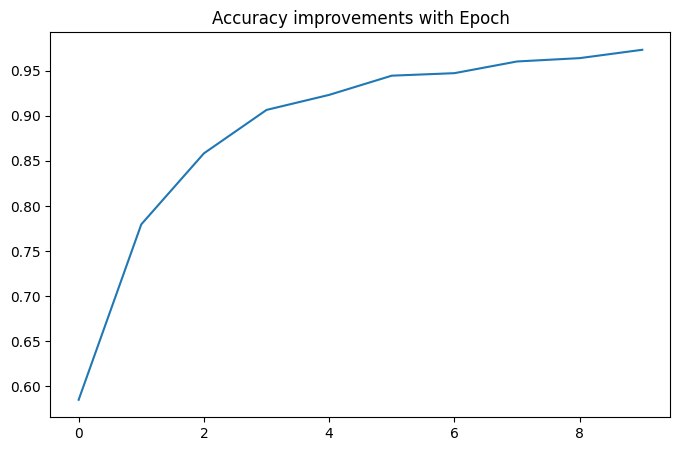


Evaluation against Test Dataset :
------------------------------------
5/5 [==============================] - 0s 6ms/step - loss: 0.3897 - accuracy: 0.9267


[0.38970527052879333, 0.9266666769981384]

In [23]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training
BATCH_SIZE=256
EPOCHS=10
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

history=model.fit(X_train,Y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=VERBOSE,validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")
import matplotlib.pyplot as plt

pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

# **5.4. Predicting for Text**

In [24]:
#Predict for multiple samples using batch processing

#Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(["FREE entry to a fun contest", "Yup I will come over"]).toarray()

print(predict_tfidf.shape)

#Predict using model
prediction=np.argmax( model.predict(predict_tfidf), axis=1 )
print("Prediction Output:" , prediction)

#Print prediction classes
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(2, 4566)
1/1 [==============================] - 0s 73ms/step
Prediction Output: [1 0]
Prediction Classes are  ['spam' 'ham']
